In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import os
import matplotlib.pyplot as plt
from torch.optim import Adam

print(torch.__version__)

1.0.1.post2


data reader

In [2]:
class Weedread(Dataset):
    def __init__(self, name, transform=None):
        hf = h5py.File(name, 'r')
        self.input_images = np.array(hf.get('data'))
        self.target_labels = np.array(hf.get('labels')).astype(np.long)
        self.transform = transform
        hf.close()

    def __len__(self):
        return self.input_images.shape[0]

    def __getitem__(self, idx):
        images = self.input_images[idx]
        labels = self.target_labels[idx]
        if self.transform is not None:
            images = self.transform(images)
        images = images / 255.0
        
        return images, labels

build model

In [3]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

class My_Model(nn.Module):
    def __init__(self, input_channel=1, num_class=10):
        super(My_Model, self).__init__()
        self.model_ft = models.resnet18(pretrained=True)
        set_parameter_requires_grad(self.model_ft, False)
        num_ftrs = self.model_ft.fc.in_features
        self.model_ft.fc = nn.Linear(num_ftrs, num_class)
    
    def forward(self, x):
        # Perform the usual forward pass
        x = self.model_ft(x)
        return F.softmax(x, dim=1)
        return x

show data

In [4]:
NUM_CLASS = 21
INPUT_CHANNEL = 3
BATCH_SIZE = 64
EPOCHS = 5
normalize = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

data_path = os.path.dirname(os.getcwd()) + "/data/weed/"
Train_data = Weedread(data_path + "train96_21.h5", transform=normalize)
Test_data = Weedread(data_path + "val96_21.h5", transform=normalize)

Train_dataloader = DataLoader(dataset=Train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True)
Test_dataloader = DataLoader(dataset=Test_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True)

torch.Size([64, 3, 96, 96])


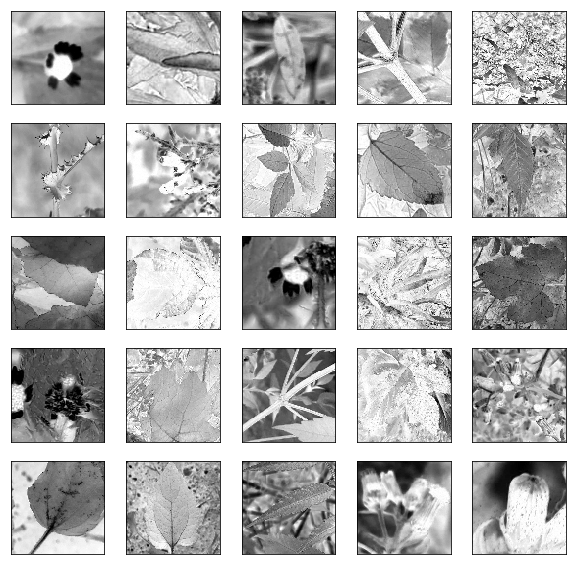

In [5]:
train_images, train_labels = next(iter(Train_dataloader))
print(train_images.size())
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i][0], cmap=plt.cm.binary)
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

initialize the model

In [6]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_model = My_Model(num_class = NUM_CLASS)
_model.to(device)
summary(_model, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

Training

In [7]:
from tqdm import tqdm_notebook

optimizer = torch.optim.SGD(_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    for image, label in tqdm_notebook(Train_dataloader):
        image, label = image.to(device), label.to(device)
        image = image.float()
        output = _model(image)
        #print(output)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Loss :{:.4f} Epoch[{}/{}]'.format(loss.item(), epoch, EPOCHS))


Loss :2.5205 Epoch[1/5]



Loss :2.5132 Epoch[2/5]



Loss :2.4560 Epoch[3/5]



Loss :2.3372 Epoch[4/5]



Loss :2.2686 Epoch[5/5]


Testing

In [8]:
with torch.no_grad():
    correct = 0
    total = 0
    for image, label in tqdm_notebook(Test_dataloader):
        image = image.to(device)
        image = image.float()
        label = label.to(device)
        outputs = _model(image)
        predicted = torch.argmax(outputs,dim=1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the test images: 77.6655954722049 %
